In [1]:
# 1) Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import pickle

sns.set(style="whitegrid")
%matplotlib inline

In [2]:
# 2) Carga de datos

df = pd.read_csv(r"C:/Users/cecil/Downloads/cliente_tienda.csv")  # ajusta ruta si se requiere
df.head()

,CustomerID,Genero,Edad,Ingresos Anuales ($),Porcentajde de gastos (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# 3) Inspección rápida

print(df.shape)
print(df.info())
print(df.describe())


(200, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   CustomerID                     200 non-null    int64 
 1   Genero                         200 non-null    object
 2   Edad                           200 non-null    int64 
 3   Ingresos Anuales ($)           200 non-null    int64 
 4   Porcentajde de gastos (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
       CustomerID        Edad  Ingresos Anuales ($)  \
count  200.000000  200.000000            200.000000   
mean   100.500000   38.850000             60.560000   
std     57.879185   13.969007             26.264721   
min      1.000000   18.000000             15.000000   
25%     50.750000   28.750000             41.500000   
50%    100.500000   36.000000             61.500000   
75%    150.250000   49.000000     

In [4]:
# 4) Limpieza mínima y detección de outliers/typos
# Revisa si la columna "Ingresos Anuales ($)" tiene valores raros (ej: 833 en último registro).
# Si hay un error tipográfico y debería ser 83 o 8330, decide y corrige. Aquí lo dejamos como está
# pero mostramos los máximos para inspección:
print("Máximo ingreso:", df["Ingresos Anuales ($)"].max())
print(df.loc[df["Ingresos Anuales ($)"] > 1000])  # si aparece algo raro lo inspeccionas

# Si detectas que el último valor es un typo (ej 833 -> 83), corrígelo manualmente:
# df.loc[df['CustomerID']==200, 'Ingresos Anuales ($)'] = 83  # solo si confirmas que es typo

Máximo ingreso: 137
Empty DataFrame
Columns: [CustomerID, Genero, Edad, Ingresos Anuales ($), Porcentajde de gastos (1-100)]
Index: []


In [5]:
# 5) Preprocesamiento
# Convertir Género a numérico (opcional, KMeans no lo necesita si no lo usamos)
le = LabelEncoder()
df['Genero_num'] = le.fit_transform(df['Genero'])  # Female->0/Male->1 (dependiendo del orden)

# Selección de características para clustering
features = ['Edad', 'Ingresos Anuales ($)', 'Porcentajde de gastos (1-100)']
X = df[features].copy()

# Imputar por mediana si hay NaN
X = X.fillna(X.median())

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


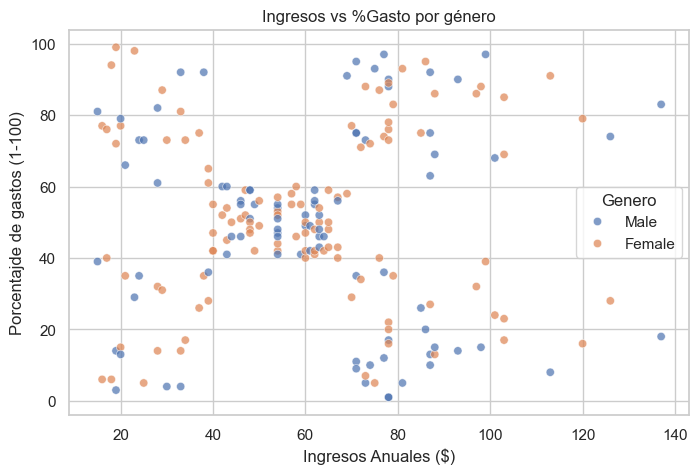

In [6]:
# 6) Análisis exploratorio rápido
plt.figure(figsize=(8,5))
sns.scatterplot(x='Ingresos Anuales ($)', y='Porcentajde de gastos (1-100)', hue='Genero', data=df, alpha=0.7)
plt.title('Ingresos vs %Gasto por género')
plt.show()

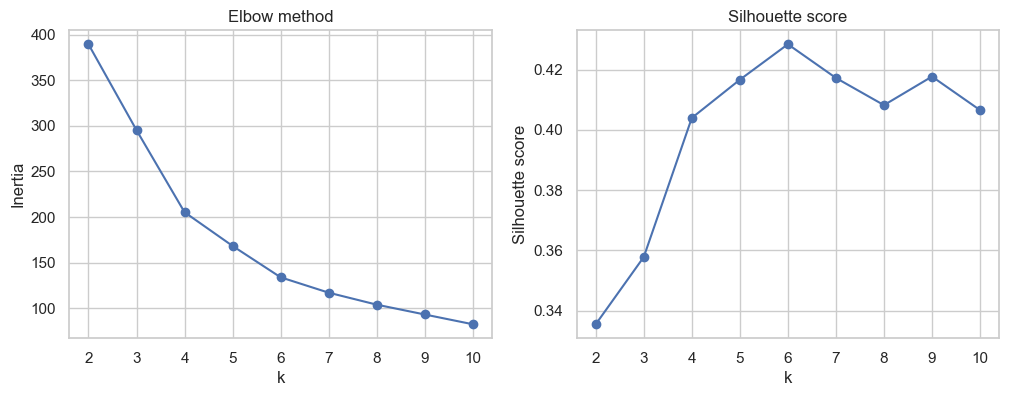

In [7]:
# 7) Elegir número de clusters (Elbow + Silhouette)
inertias = []
sil_scores = []
K_range = range(2,11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(K_range, inertias, '-o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow method')

plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, '-o')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette score')
plt.show()


In [8]:
# 8) Entrenar KMeans con k elegido (ej: k=4) - elige según las curvas anteriores
k_opt = 4  # cambia según Elbow/Silhouette
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=50)
labels = kmeans.fit_predict(X_scaled)
df['cluster'] = labels

# Centroides (en escala original)
centroids_scaled = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids_scaled)
centroids_df = pd.DataFrame(centroids, columns=features)
centroids_df['cluster'] = range(k_opt)
print("Centroides (valores originales):")
display(centroids_df)

# Tamaño de clusters
print(df['cluster'].value_counts().sort_index())

Centroides (valores originales):


,Edad,Ingresos Anuales ($),Porcentajde de gastos (1-100),cluster
0,53.984615,47.707692,39.969231,0
1,32.875000,86.100000,81.525000,1
2,25.438596,40.000000,60.298246,2
3,39.368421,86.500000,19.578947,3


cluster
0    65
1    40
2    57
3    38
Name: count, dtype: int64


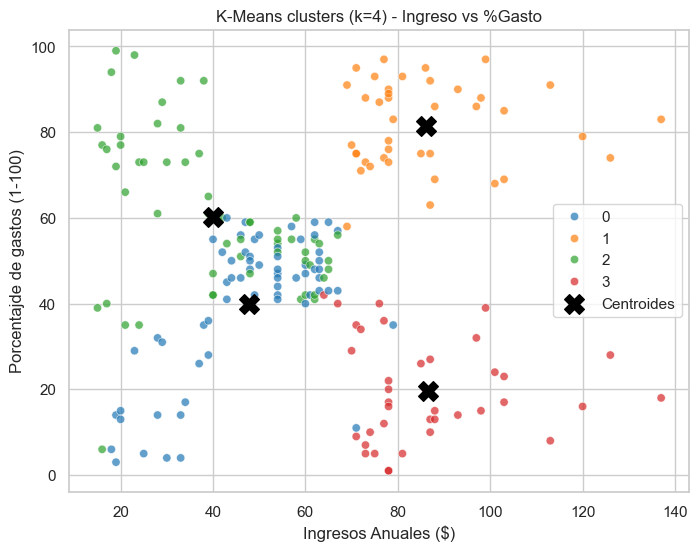

In [9]:
# 9) Visualización clusters: Ingresos vs %Gasto
plt.figure(figsize=(8,6))
sns.scatterplot(x='Ingresos Anuales ($)', y='Porcentajde de gastos (1-100)', hue='cluster', palette='tab10', data=df, alpha=0.7)
plt.scatter(centroids_df['Ingresos Anuales ($)'], centroids_df['Porcentajde de gastos (1-100)'], s=200, c='black', marker='X', label='Centroides')
plt.title(f'K-Means clusters (k={k_opt}) - Ingreso vs %Gasto')
plt.legend()
plt.show()


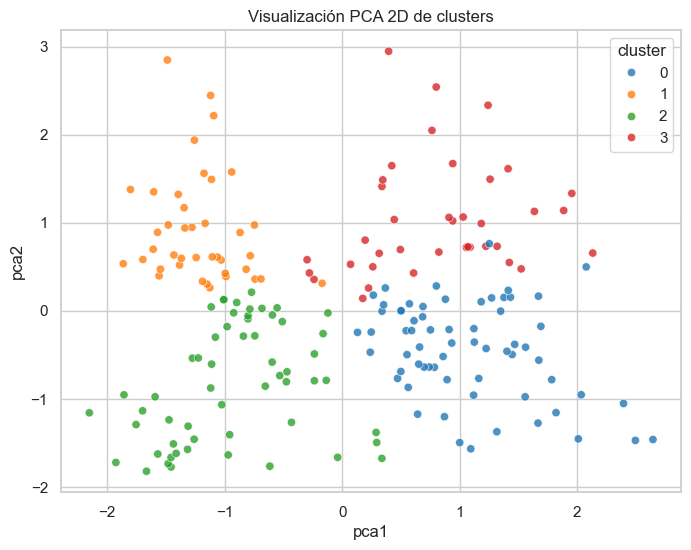

In [10]:
# 10) Visualización clusters con PCA (2D)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df['pca1'] = X_pca[:,0]
df['pca2'] = X_pca[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', palette='tab10', data=df, alpha=0.8)
plt.title('Visualización PCA 2D de clusters')
plt.show()

In [11]:
# 11) Silhouette promedio del k final
sil = silhouette_score(X_scaled, labels)
print("Silhouette score (k={}): {:.3f}".format(k_opt, sil))


Silhouette score (k=4): 0.404
